In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import ot

from functions import *
from noisy_graphs import *
from sample_graphs import *
from frank_wolfe import *
from grampa import *
from eigenalign import *
from isorank import *

In [2]:
#G = nx.read_edgelist('./graphs/collaboration_astrophysics')
#A = nx.adjacency_matrix(G).todense()
#print("Number of nodes:", G.number_of_nodes())
#print("Number of edges:", G.number_of_edges())

In [3]:
#Gprime = nx.Graph.copy(G)
#B = nx.adjacency_matrix(Gprime)

# now run your algorithm on (G, Gprime) or on (A, B) !
#print("Number of nodes:", G.number_of_nodes())
#print("Number of edges:", G.number_of_edges())

In [4]:
# G and Gprime are too big (in memory) for computation
# new dataset


n = 50
p = 0.4

A_eq, b_eq =  bistochastic_equality_constraints(n)

G0, G1, A0, A1 = sample_correlated_geometric(n, p, d=3, s=0.9)
Ps = rand_perm_matrix(n)
print(G0)
print(G1)


Graph with 50 nodes and 522 edges
Graph with 50 nodes and 524 edges


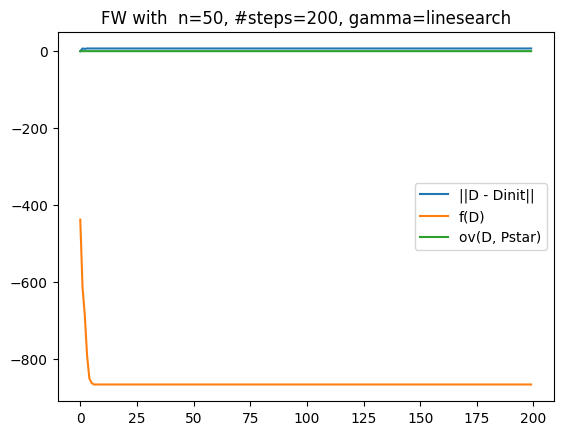

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [5]:
#Frank_wolfe algorithm

D = frank_wolfe(A0, A1, 200, Pstar=Ps , method="minustrace",plot=True)
print(D)
# minustrace more efficient than mindiff ??

18.973665961010276


np.float64(0.06)

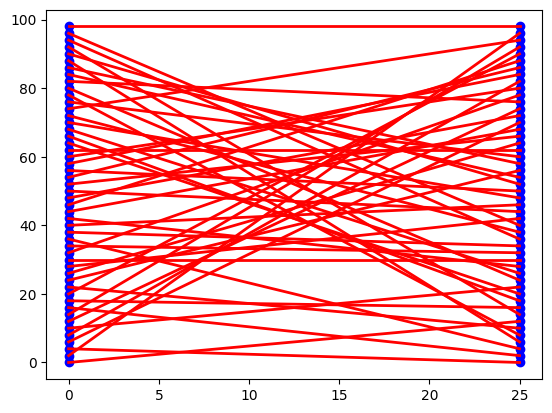

In [6]:
Dp = project_to_perm(D, A_eq, b_eq)

# we want to see how Dp appair these two graphs
plot_alignment(G0, G1, D)
print(np.linalg.norm(A0.toarray() - D @ A1.toarray() @ D.T))
overlap(np.eye(n), Dp)

18.973665961010276


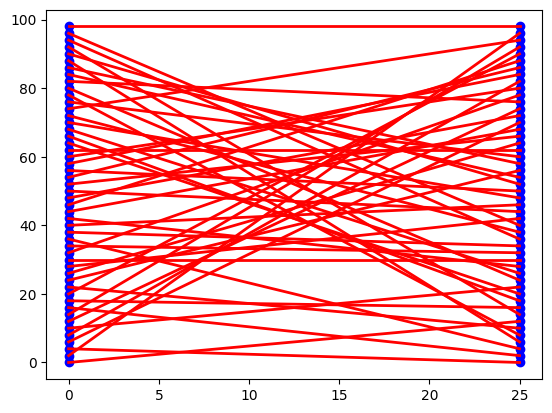

In [7]:
plot_alignment(G0,G1, Dp)
print(np.linalg.norm(A0.toarray() - Dp @ A1.toarray() @ Dp.T))

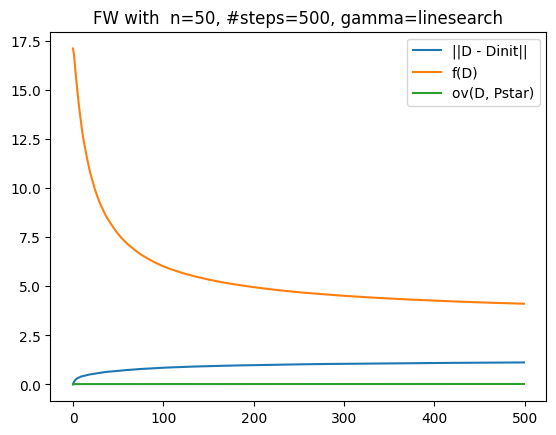

In [8]:
D1 = frank_wolfe(A0, A1, 500, Pstar=Ps , method="mindiff",plot=True)


20.93920108377418


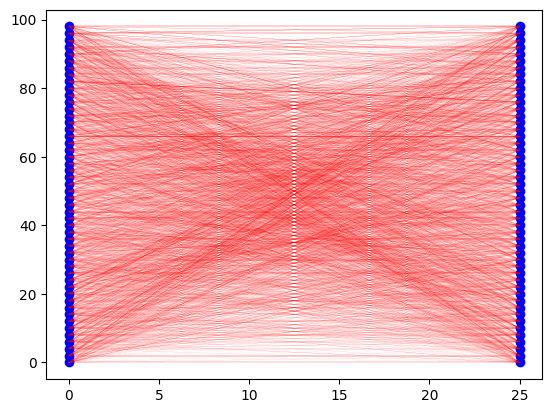

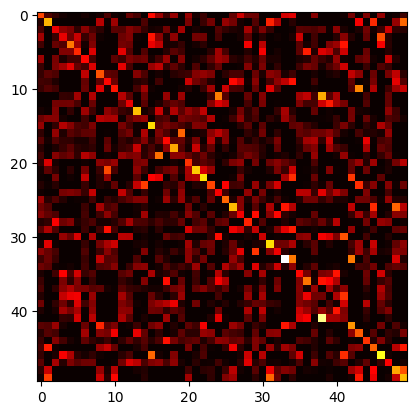

In [9]:
D1p = project_to_perm(D1, A_eq, b_eq)

# we want to see how Dp appair these two graphs
plot_alignment(G0, G1, D1)
print(np.linalg.norm(A0.toarray() - D1 @ A1.toarray() @ D1.T))
plt.show()
matrix_heatmap(D1)

13.114877048604


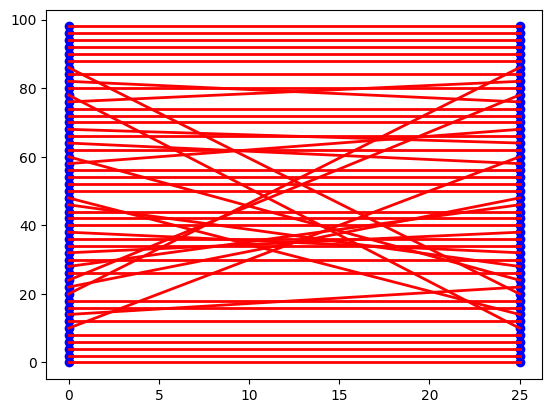

In [10]:
plot_alignment(G0, G1, D1p)
print(np.linalg.norm(A0.toarray() - D1p @ A1.toarray() @ D1p.T))

36.823905279043935


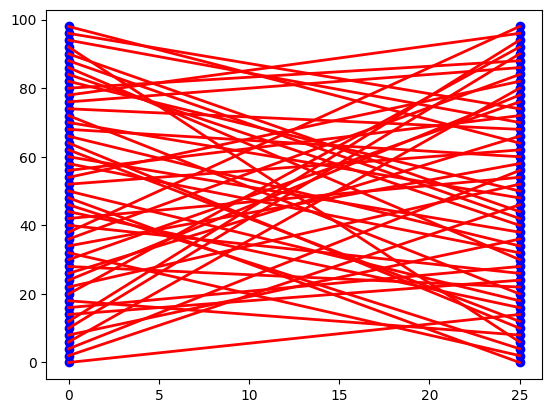

In [11]:
#GRAMPA ?

eta = 0.1
D2 = grampa(A0.toarray(), A1.toarray(), eta)
plot_alignment(G0, G1, D2)
print(np.linalg.norm(A0.toarray() - D2 @ A1.toarray() @ D2.T))

24.0


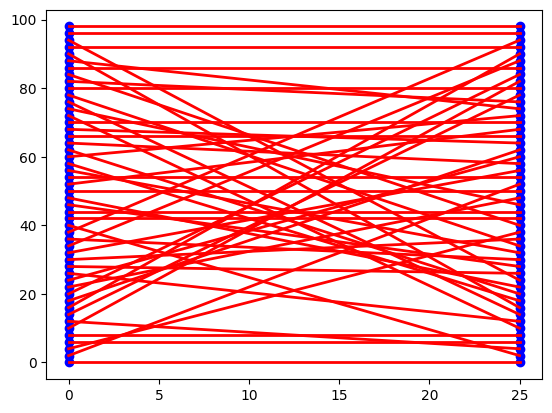

In [12]:
#Better(?) GRAMPA from https://github.com/cheng-mao/grampa/blob/master/grampa.m
D3 = grampa_matlab(A0.toarray(), A1.toarray(), eta)
plot_alignment(G0, G1, D3)
print(np.linalg.norm(A0.toarray() - D3 @ A1.toarray() @ D3.T))

In [13]:
EigP = eigenalign(G0, G1, 1, 0.5, 0.1)

35.4964786985977
0.02


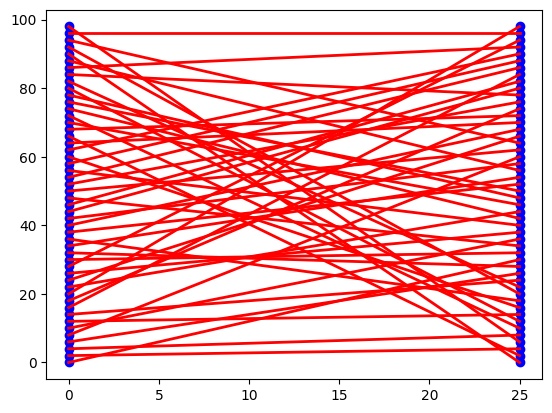

In [14]:
plot_alignment(G0, G1, EigP)
print(np.linalg.norm(A0.toarray() - EigP @ A1.toarray() @ EigP.T))
print(overlap(EigP, np.eye(n)))


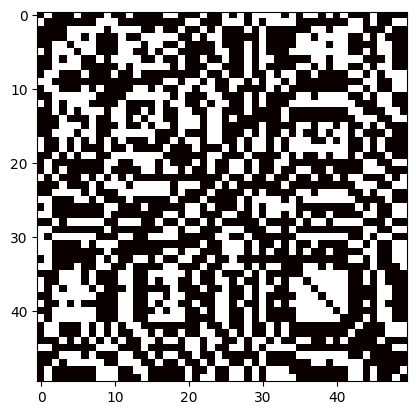

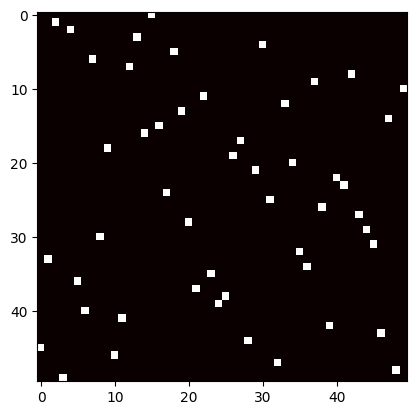

In [15]:
matrix_heatmap(A0.toarray())
plt.plot()
matrix_heatmap(EigP)

34.92849839314596
0.02


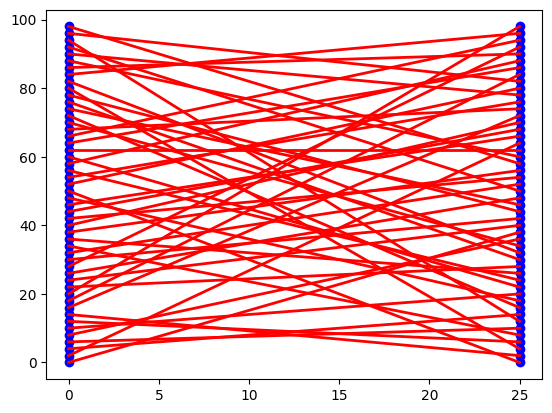

In [16]:
isor = isorank(G0, G1)
plot_alignment(G0, G1, isor)

print(np.linalg.norm(A0.toarray() - isor @ A1.toarray() @ isor.T))
print(overlap(isor, np.eye(n)))



10.392304845413264
0.8200000000000001


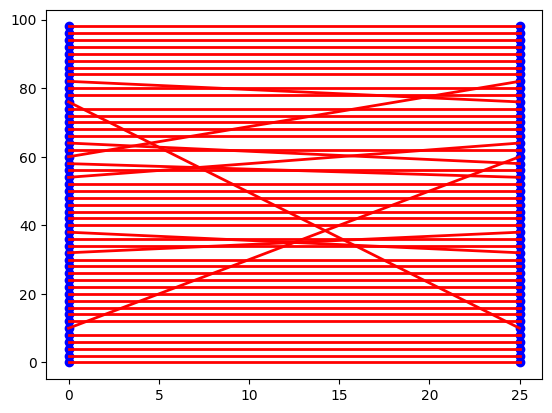

In [17]:
A0 = (A0).astype(float)
A1 = (A1).astype(float)
T = ot.gromov.entropic_gromov_wasserstein(A0.toarray(), A1.toarray(),epsilon=0.1, loss_fun='square_loss')
Tp = project_to_perm(T, A_eq, b_eq)
plot_alignment(G0, G1, Tp)
plt.plot()
print(np.linalg.norm(A0.toarray() - Tp @ A1.toarray() @ Tp.T))
print(overlap(Tp, np.eye(n)))

11.832159566199232
0.76


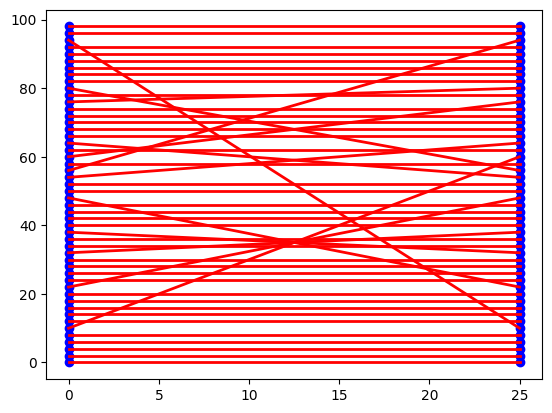

In [18]:
T = greedy_to_perm(T)
print(np.linalg.norm(A0.toarray() - T @ A1.toarray() @ T.T))
print(overlap(T, np.eye(n)))
plot_alignment(G0, G1, T)

10.583005244258363
0.76


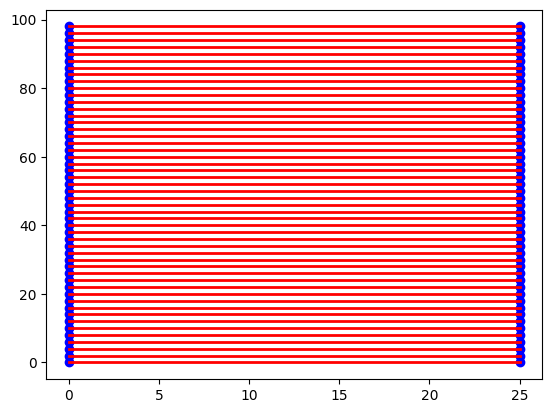

In [19]:
#Identity ?
print(np.linalg.norm(A0.toarray() -  A1.toarray()))
print(overlap(T, np.eye(n)))
plot_alignment(G0, G1, np.eye(n))

In [41]:
#Test on correlated geometric graphs : identity most efficient when very correlated graphs

def normise(L, A, B):
    return np.linalg.norm(A.toarray() - L @ B.toarray() @ L.T)

def construit_liste(n1, n2, p, s):
    x = np.arange(n1, n2, 2)
    Label = ['FWtrace', 'FWmindiff', 'Grampa', 'Grampa_matlab','Isorank', 'Entropic GW', 'id']
    L = []
    Lo = []
    for i in x:
        print(i)
        A_eq, b_eq = bistochastic_equality_constraints(i)
        G0, G1, A0, A1 = sample_correlated_geometric(i, p, 3, s)
        Li = []
        Li2 = []
        Fw = project_to_perm(frank_wolfe(A0, A1, 200, Pstar=Ps , method="minustrace",plot=False), A_eq, b_eq)
        Li.append(normise(Fw, A0, A1)) #FW minustrace
        Li2.append(overlap(np.eye(i), Fw))
        Fw_mindiff = project_to_perm(frank_wolfe(A0, A1, 200, Pstar=Ps , method="mindiff",plot=False), A_eq, b_eq)
        Li.append(normise(Fw_mindiff, A0, A1)) #FW mindiff
        Li2.append(overlap(np.eye(i), Fw_mindiff))
        Grampa = grampa(A0.toarray(), A1.toarray(), eta)
        Li.append(normise(Grampa, A0, A1)) #Grampa
        Li2.append(overlap(np.eye(i), Grampa))
        Grampa_matlab = grampa_matlab(A0.toarray(), A1.toarray(), eta)
        Li.append(normise(Grampa_matlab, A0, A1)) #Grampa_matlab
        Li2.append(overlap(np.eye(i), Grampa_matlab))
        Isorank = isorank(G0, G1)
        Li.append(normise(Isorank, A0, A1))#isorank
        Li2.append(overlap(np.eye(i), Isorank))
        EntropicGW = project_to_perm(ot.gromov.entropic_gromov_wasserstein(A0.toarray(), A1.toarray(),epsilon=0.1, loss_fun='square_loss'), A_eq, b_eq)
        Li.append(normise(EntropicGW, A0, A1))#EntropicGW
        Li2.append(overlap(np.eye(i), EntropicGW))
        Li2.append(overlap(np.eye(i), np.eye(i)))
        Li.append(normise(np.eye(i), A0, A1))
        L.append(Li)
        Lo.append(Li2)
    return L, Lo, Label, x



L, Lo, Label, x= construit_liste(10, 30, 0.4, 0.9)

10
12
14
16
18
20
22
24
26
28


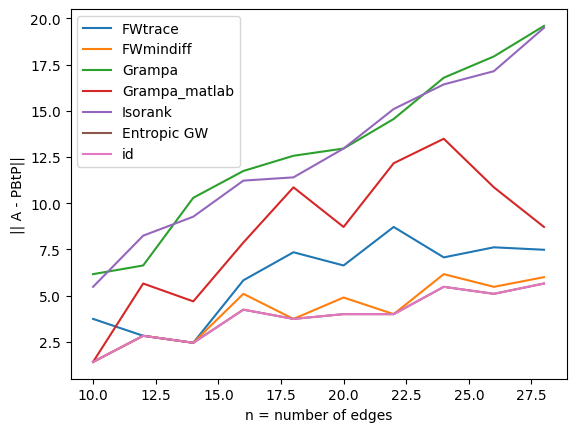

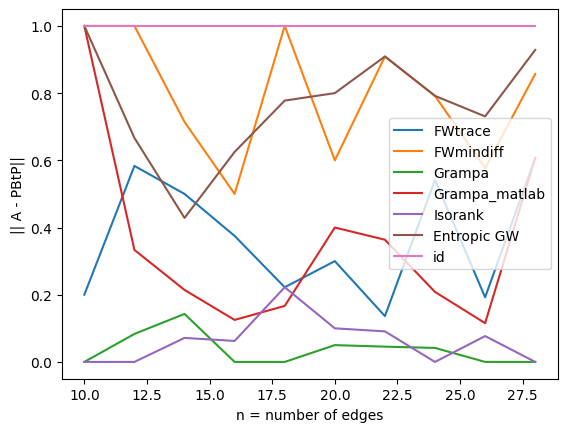

In [42]:
norm_plot(L, Label, x)
plt.show()
norm_plot(Lo, Label, x)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30] [0.2        0.27777778 0.35555556 0.43333333 0.51111111 0.58888889
 0.66666667 0.74444444 0.82222222 0.9       ] [0.9        0.84444444 0.78888889 0.73333333 0.67777778 0.62222222
 0.56666667 0.51111111 0.45555556 0.4       ]
n =  30
p =  0.2
s =  0.9
10
12
14
16
18
20
22
24
26
28


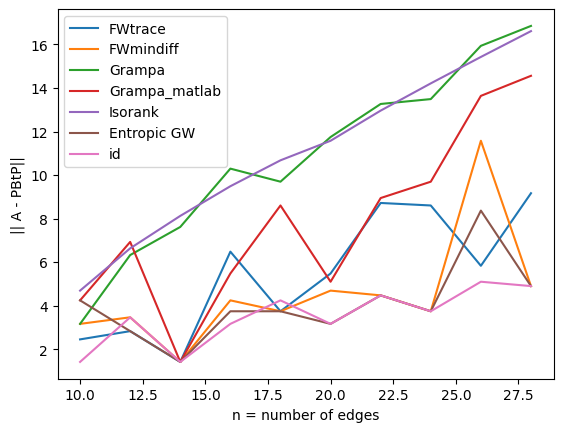

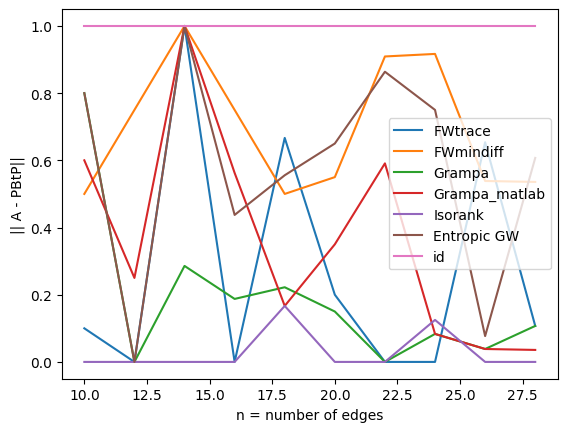

n =  30
p =  0.2777777777777778
s =  0.8444444444444444
10
12


/home/ROCQ/argo/edailly/.local/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


14
16
18
20
22
24
26
28


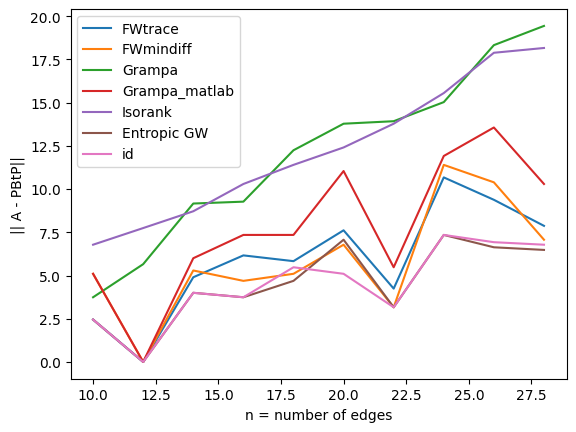

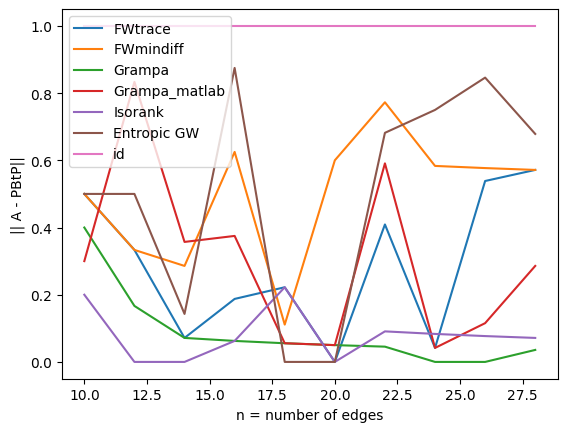

n =  30
p =  0.35555555555555557
s =  0.7888888888888889
10
12
14
16
18
20
22
24
26
28


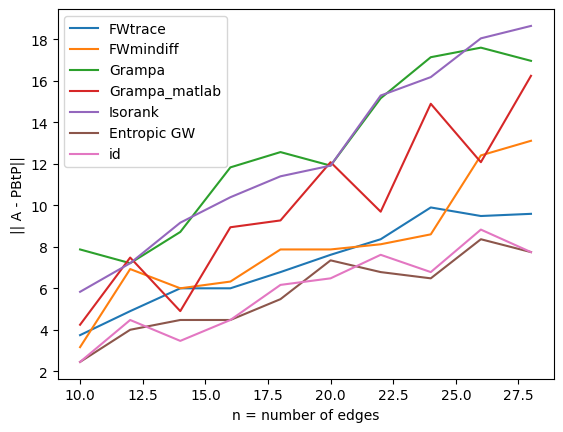

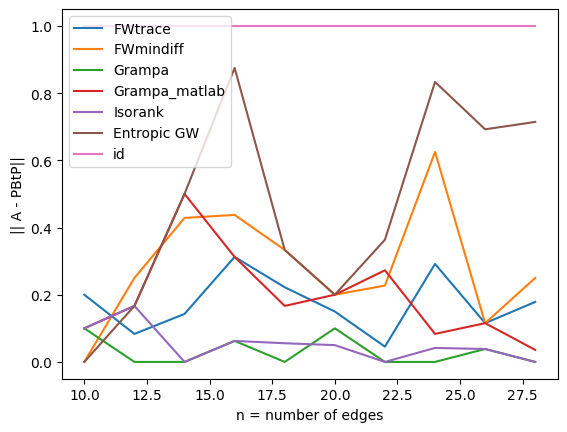

n =  30
p =  0.43333333333333335
s =  0.7333333333333334
10
12
14
16
18
20
22
24
26
28


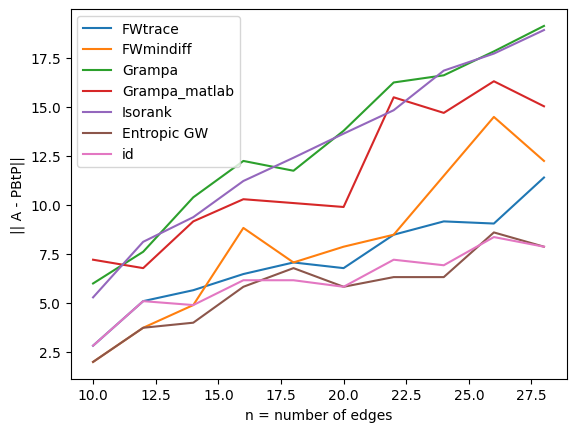

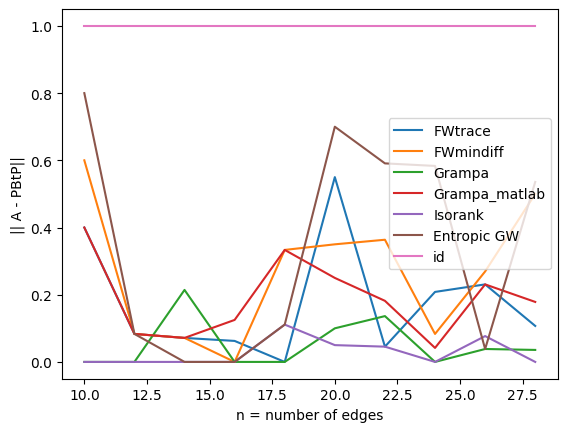

n =  30
p =  0.5111111111111111
s =  0.6777777777777778
10
12
14
16
18
20
22
24
26
28


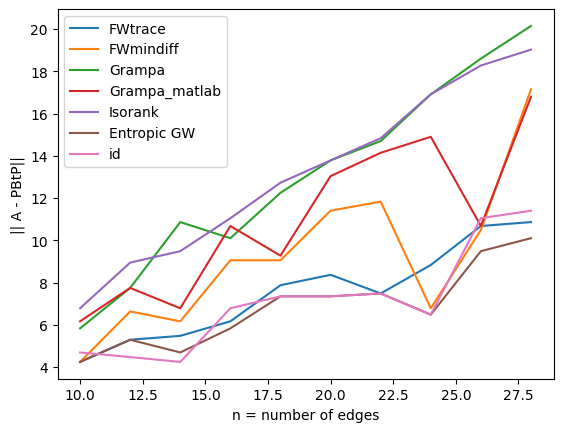

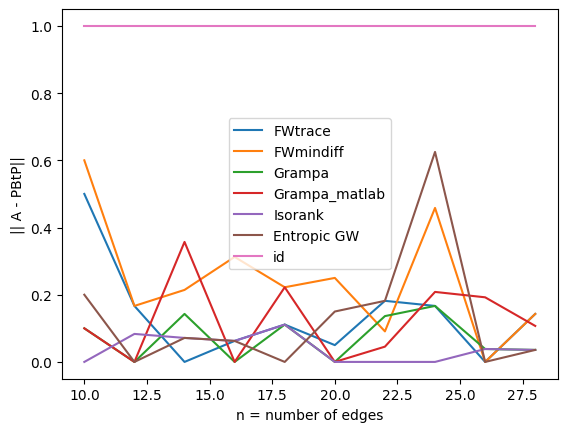

n =  30
p =  0.5888888888888889
s =  0.6222222222222222
10
12
14
16
18
20
22
24
26
28


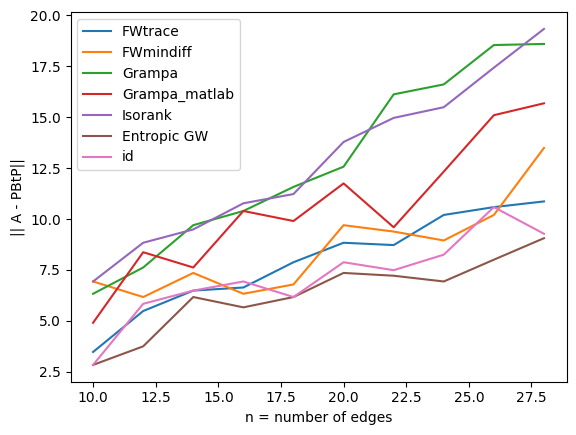

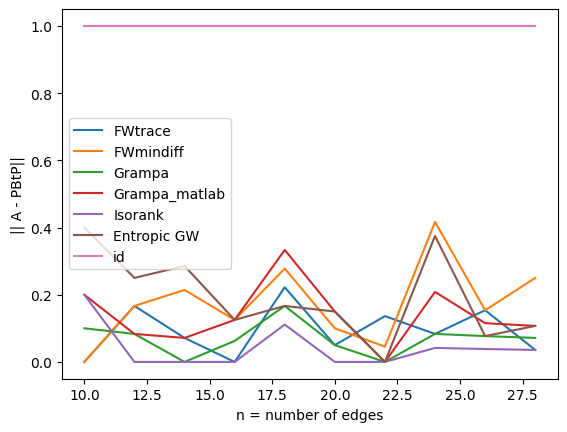

n =  30
p =  0.6666666666666667
s =  0.5666666666666667
10
12
14
16
18
20
22
24
26
28


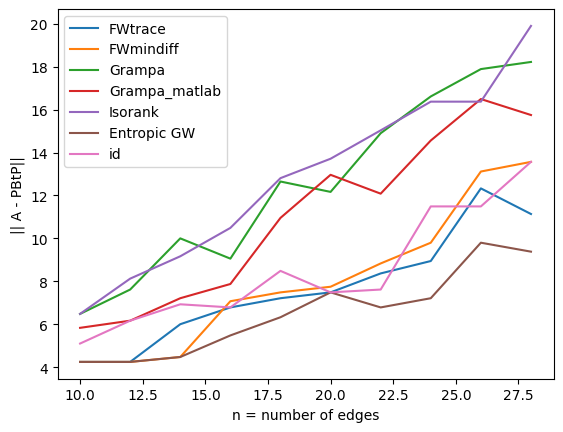

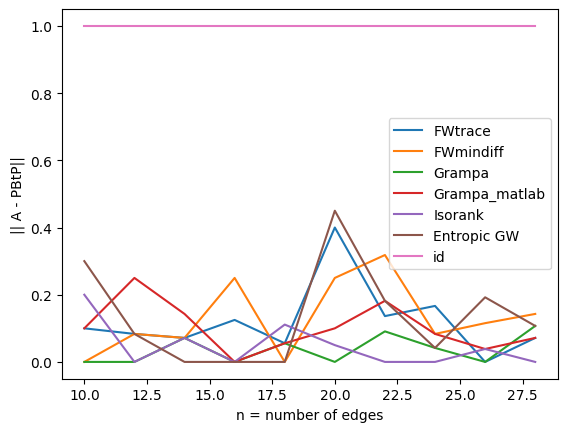

n =  30
p =  0.7444444444444445
s =  0.5111111111111111
10
12
14
16
18
20
22
24
26
28


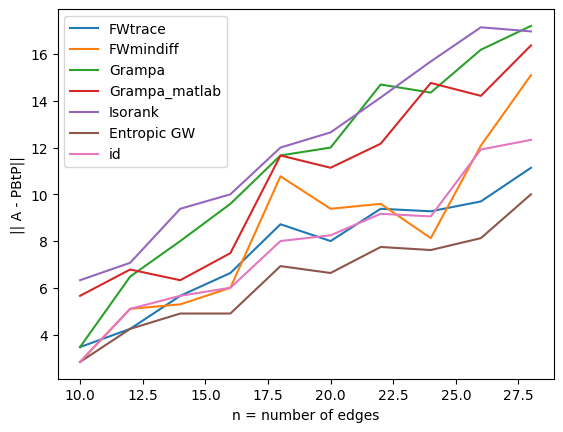

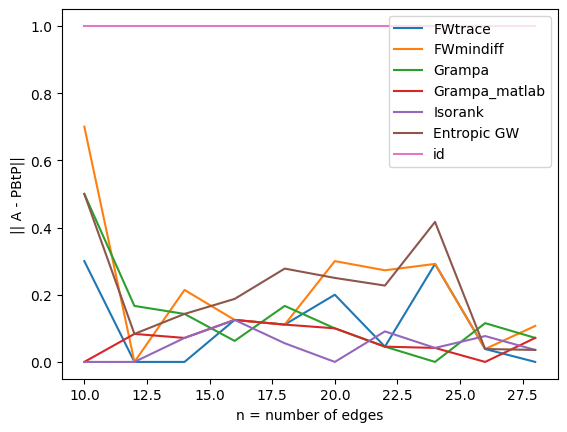

n =  30
p =  0.8222222222222222
s =  0.4555555555555556
10
12
14
16
18
20
22
24
26
28


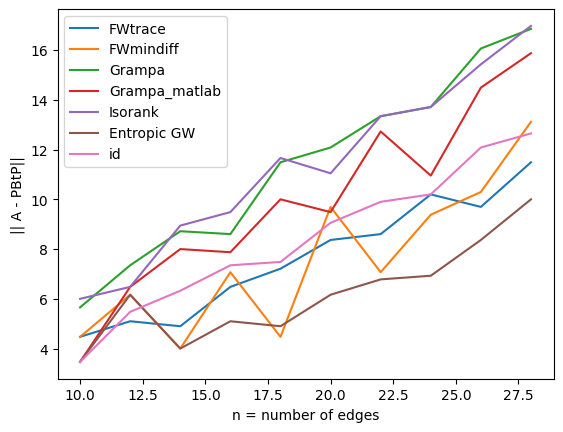

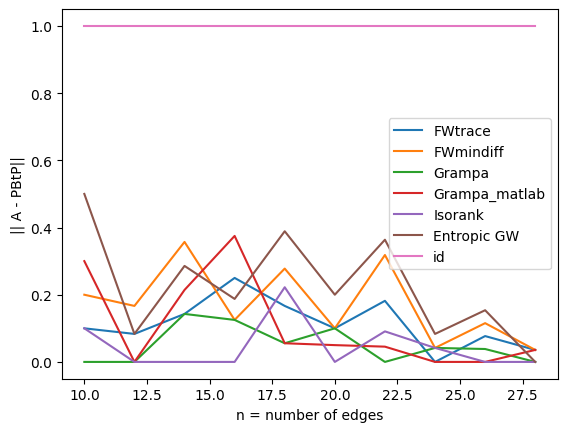

n =  30
p =  0.9
s =  0.4
10
12
14
16
18
20
22
24
26
28


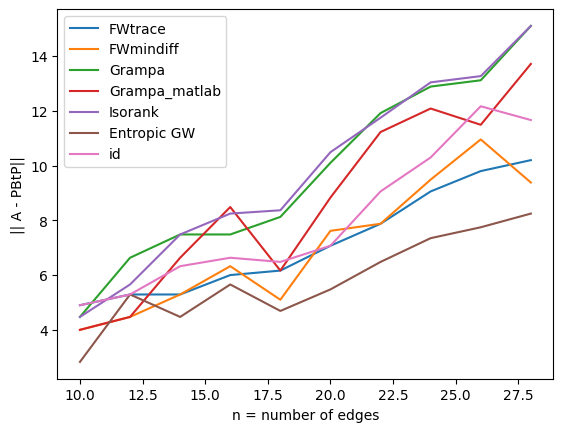

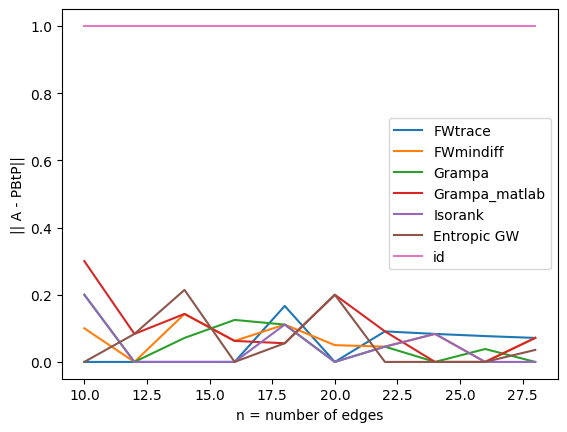

In [35]:
#Big samples

def bigdata(N, P, S): #list of same sizes
    for i in range(len(N)):
        print("n = ", N[i])
        print("p = ", P[i])
        print("s = ", S[i])
        L, Lo, Label, x= construit_liste(10, N[i], P[i], S[i])
        norm_plot(L, Label, x)
        plt.show()
        norm_plot(Lo, Label, x)
        plt.show()

N = [30] * 10
P = np.linspace(0.2, 0.9, 10)
S = np.flip(np.linspace(0.4, 0.9, 10))

print(N,P,S)

bigdata(N,P,S)

n =  30
p =  0.2
s =  0.4
10
12
14
16
18
20
22
24
26
28


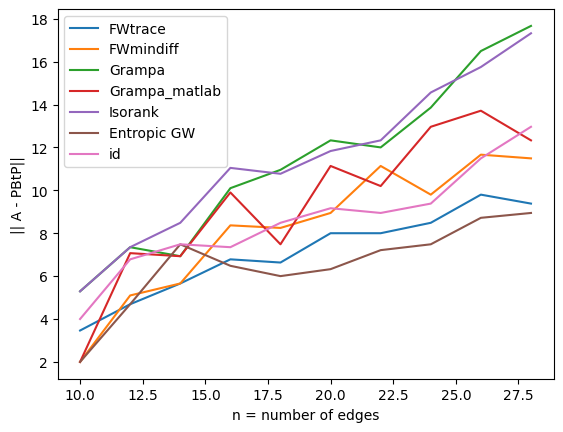

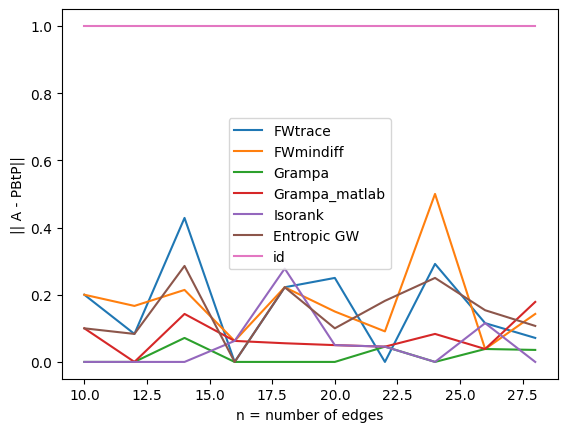

n =  30
p =  0.2777777777777778
s =  0.4555555555555556
10
12
14
16
18
20
22
24
26
28


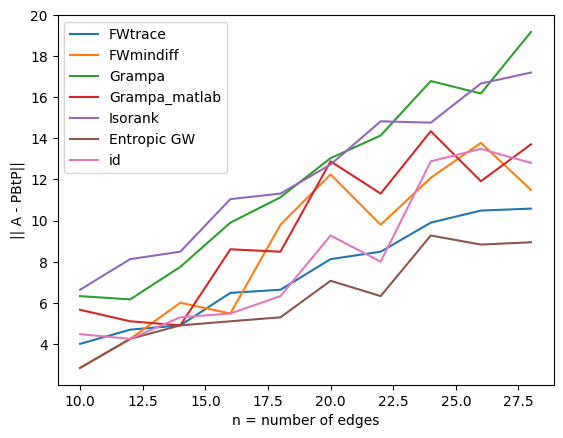

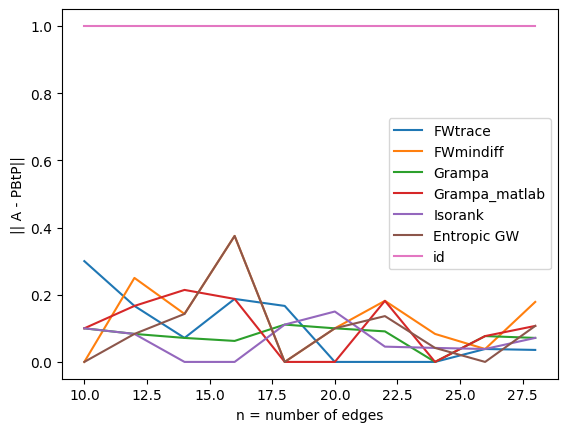

n =  30
p =  0.35555555555555557
s =  0.5111111111111111
10
12
14
16


/home/ROCQ/argo/edailly/.local/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


18
20
22
24
26
28


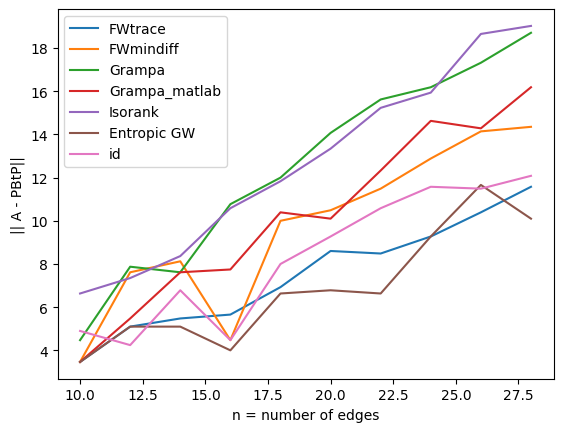

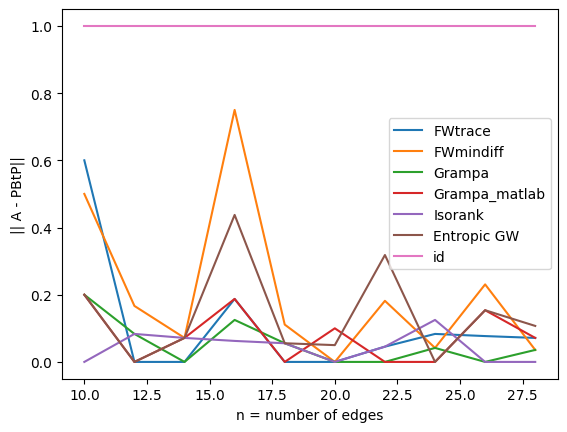

n =  30
p =  0.43333333333333335
s =  0.5666666666666667
10
12
14
16
18
20
22
24
26
28


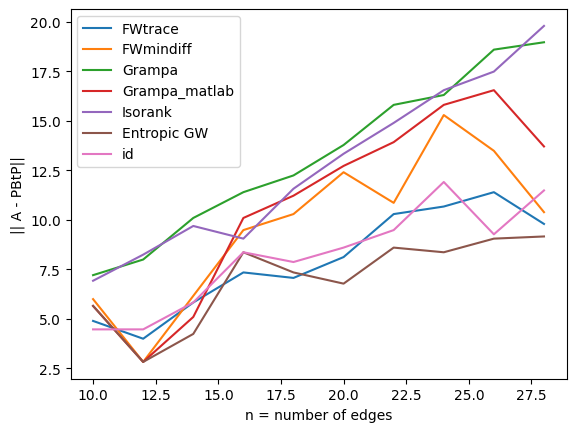

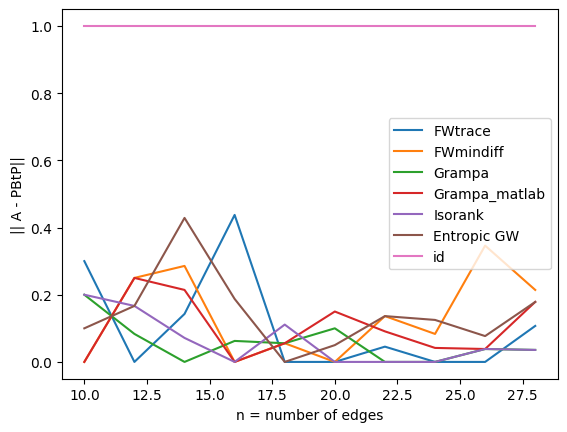

n =  30
p =  0.5111111111111111
s =  0.6222222222222222
10
12
14
16
18
20
22
24
26
28


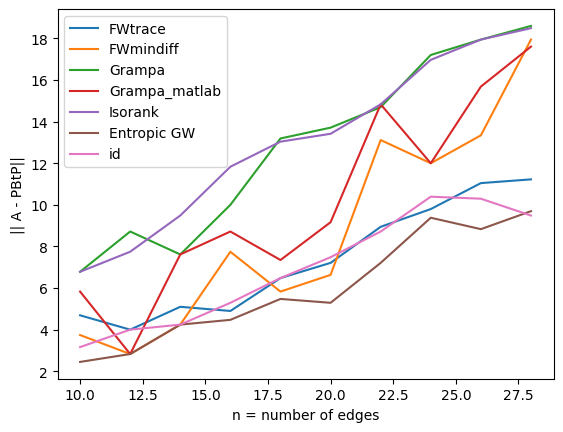

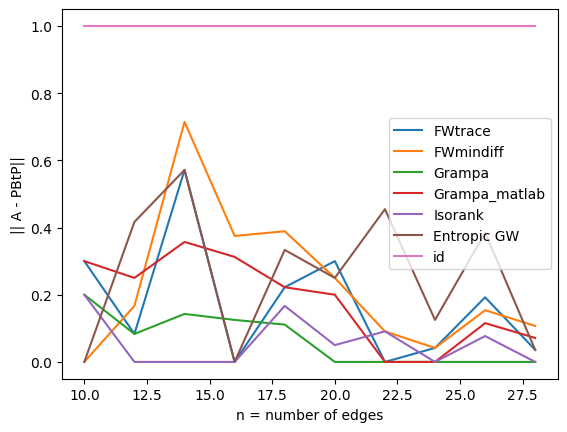

n =  30
p =  0.5888888888888889
s =  0.6777777777777778
10
12
14
16
18
20
22
24
26
28


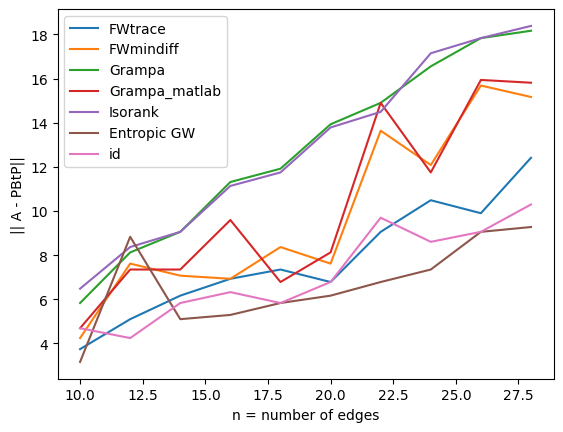

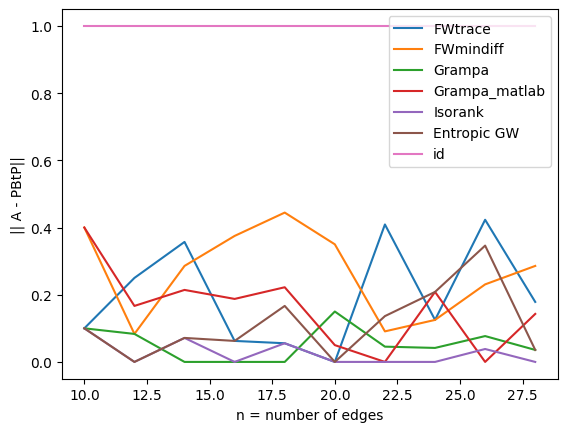

n =  30
p =  0.6666666666666667
s =  0.7333333333333334
10
12
14
16
18
20
22
24
26
28


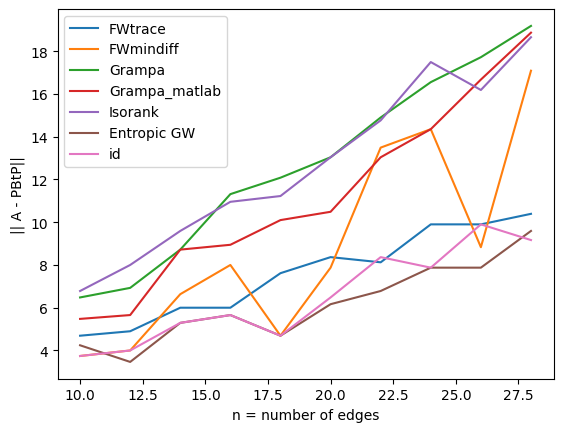

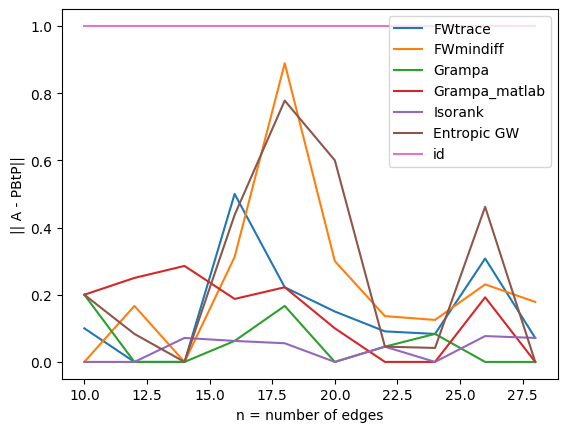

n =  30
p =  0.7444444444444445
s =  0.7888888888888889
10
12
14
16
18
20
22
24
26
28


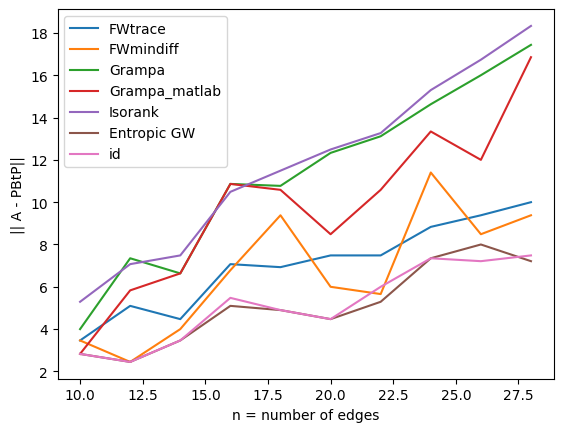

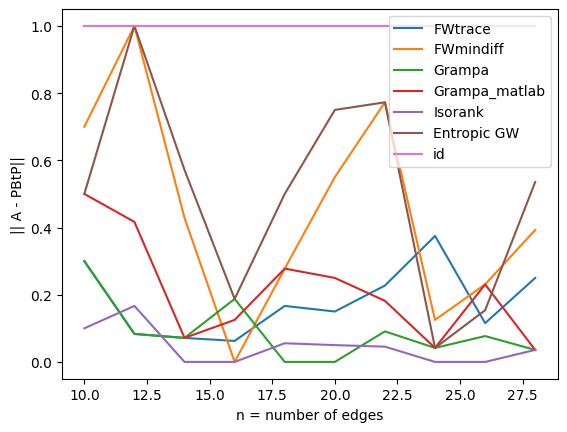

n =  30
p =  0.8222222222222222
s =  0.8444444444444444
10
12
14
16
18
20
22
24
26
28


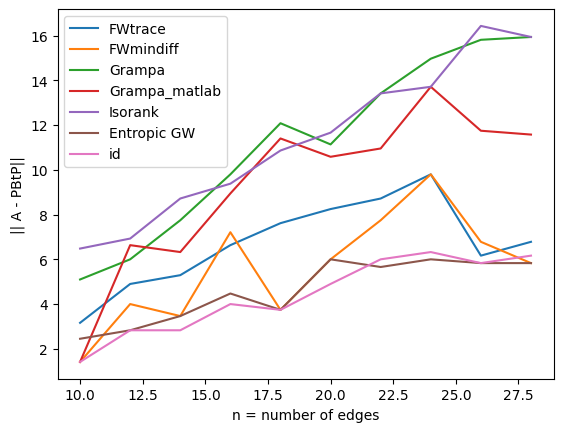

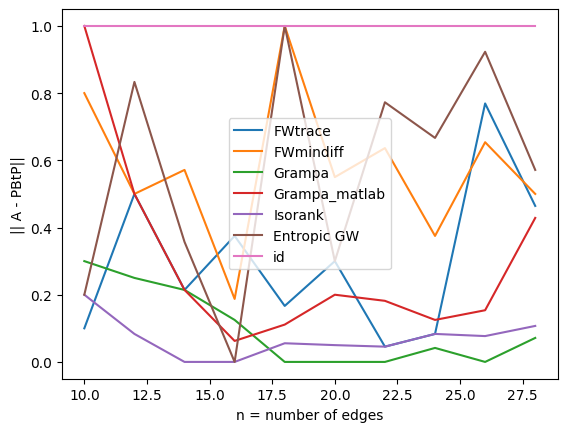

n =  30
p =  0.9
s =  0.9
10
12
14
16
18
20
22
24
26
28


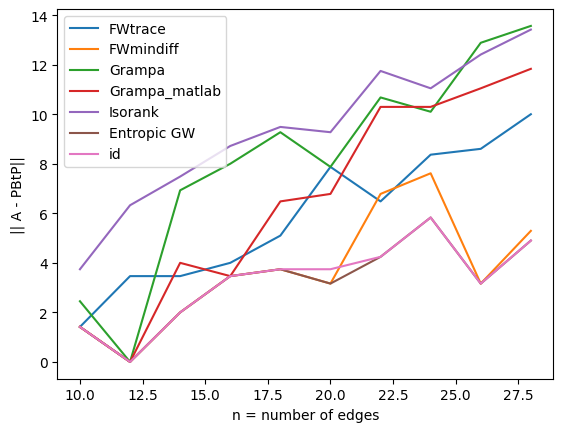

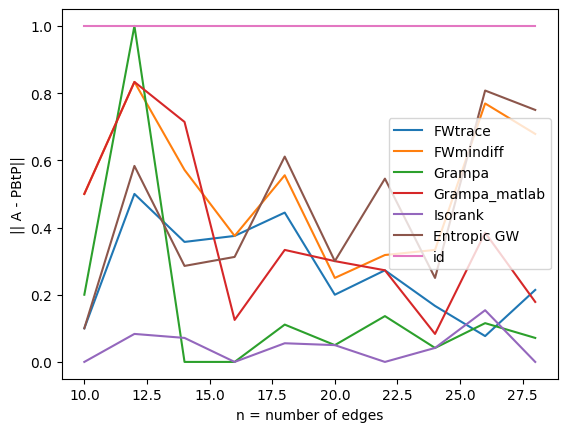

In [36]:
S = (np.linspace(0.4, 0.9, 10))
bigdata(N, P, S)

In [ ]:
#Trying with ihara
#Cannot work because only captures the geometry of one graph WITHOUT looking at particular nodes

